# Setup

In [1]:
# Data-handling imports
import pandas as pd

# Text-handling imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Graphing libraries
import matplotlib.pyplot as plt

# Random seed
seed = 5993

In [2]:
# Run this once to download VADER lexicon
# import nltk
# nltk.download('vader_lexicon')

# Data import & cleaning

In [3]:
# Read in data
df = pd.read_csv("../data/COVID.csv")

In [4]:
cities = ["Boston", "New York"]
regexes = ["^Boston", "^(?:NYC|New York|Bronx|Manhattan|Brookyn|Queens|Staten Island)"]

dfs = {}
for city, regex in zip(cities, regexes):
    # Create data frame
    dfs[city] = pd.DataFrame()
    
    # Subset original data
    mask = df["Tweet Location"].str.contains(regex, na=False)
    
    # Add columns
    dfs[city]["id"] = df[mask]["Tweet Id"]
    dfs[city]["text"] = df[mask]["Tweet Content"]
    dfs[city]["city"] = city
    dfs[city]["time"] = pd.to_datetime(df[mask]["Tweet Posted Time (UTC)"])
    
    #dfs[city].set_index("id", inplace=True)

# Compile dataframe with text
covid = pd.concat(dfs).reset_index(drop=True)
covid.set_index("id", inplace=True)

In [5]:
# Check if we're balanced across cities
covid["city"].value_counts(normalize=True) * 100

New York    83.467279
Boston      16.532721
Name: city, dtype: float64

# Sentiment analysis

In [6]:
# Instantiate sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute sentiments
sentiments = pd.DataFrame([analyzer.polarity_scores(text) for text in covid["text"]])

# Append to original data frame
covid = pd.concat([covid, sentiments.set_index(covid.index)], axis=1)

# Graphs

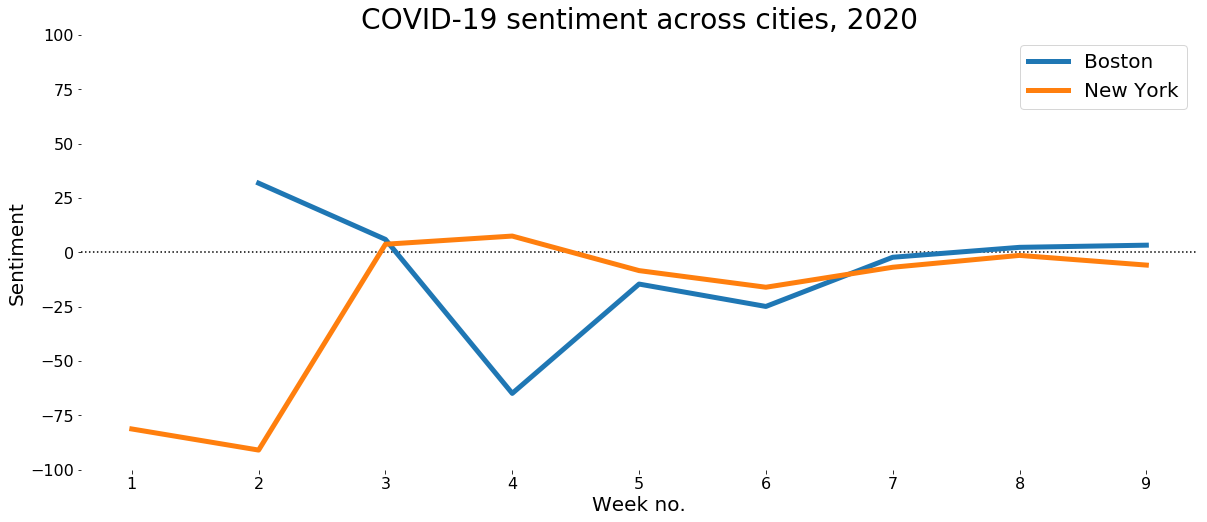

In [7]:
# Matplotlib setup
fig, ax = plt.subplots(figsize=(20, 8))

ax.set_title(f"COVID-19 sentiment across cities, 2020", fontsize=28)
ax.set_xlabel("Week no.", fontsize=20)
ax.set_ylabel("Sentiment", fontsize=20)
ax.tick_params(labelsize=16)
ax.set_ylim((-100, 100))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.axhline(0, color="black", linestyle=":")
    
for city in cities:
    subset = covid[covid["city"] == city]
    subset_mean = subset.groupby(subset["time"].dt.week).mean()
    ax.plot(subset_mean.index, subset_mean["compound"] * 100, linewidth=5, label=city);

plt.legend(fontsize=20);

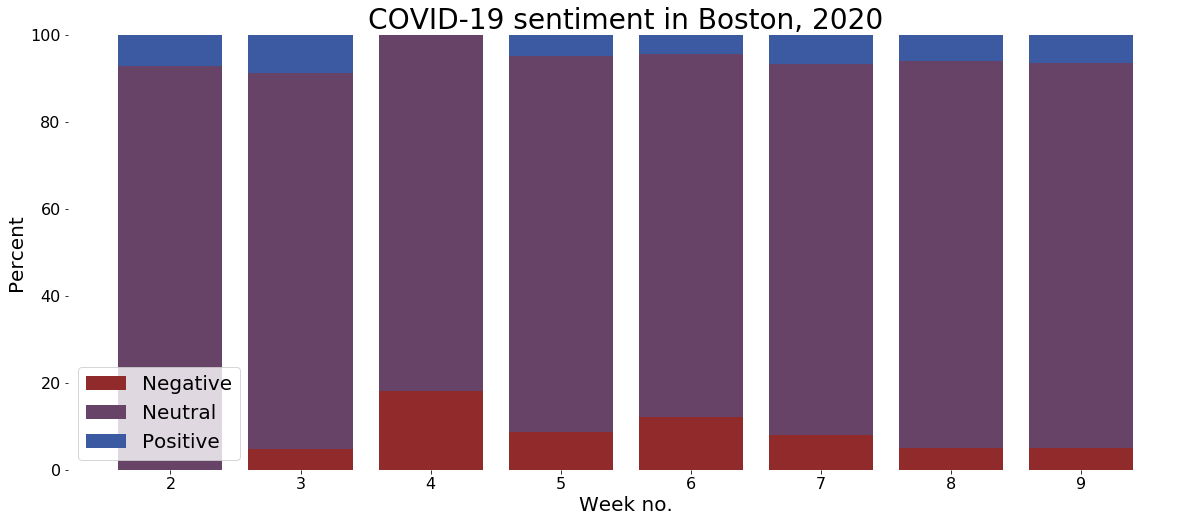

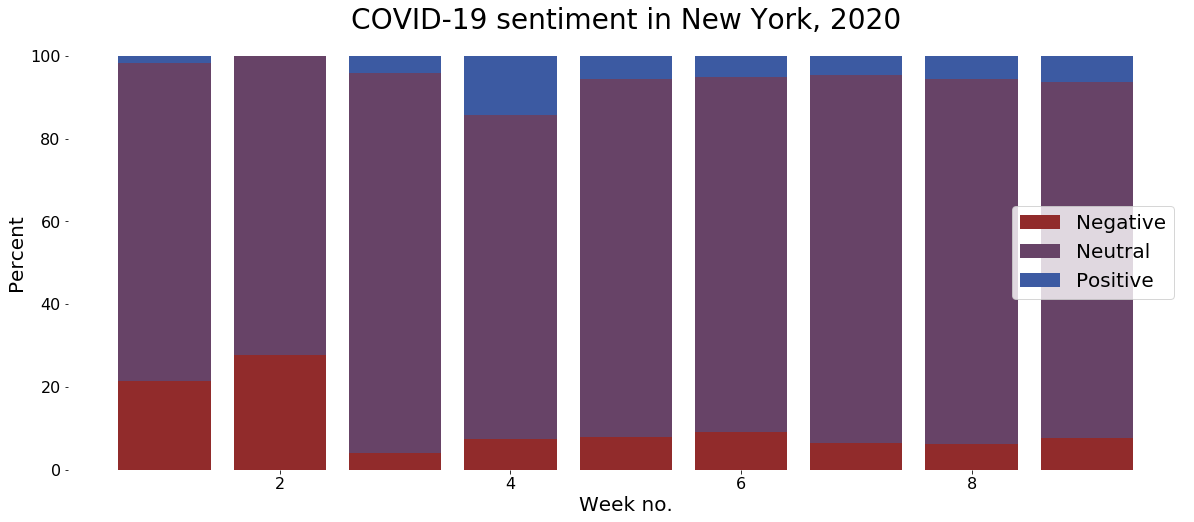

In [8]:
for city in cities:
    subset = covid[covid["city"] == city]
    subset_mean = subset.groupby(subset["time"].dt.week).mean()

    # Matplotlib setup
    fig, ax = plt.subplots(figsize=(20, 8))

    ax.set_title(f"COVID-19 sentiment in {city}, 2020", fontsize=28)
    ax.set_xlabel("Week no.", fontsize=20)
    ax.set_ylabel("Percent", fontsize=20)
    ax.tick_params(labelsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Stacked bar plot
    ax.bar(subset_mean.index, subset_mean["neg"] * 100, color="#912B2B", linewidth=5, label="Negative");
    ax.bar(subset_mean.index, subset_mean["neu"] * 100, color="#674367", linewidth=5, label="Neutral",  bottom=subset_mean["neg"] * 100);
    ax.bar(subset_mean.index, subset_mean["pos"] * 100, color="#3C5AA2", linewidth=5, label="Positive", bottom=(subset_mean["neg"] + subset_mean["neu"]) * 100);

    ax.legend(fontsize=20);

# Data export